## Above Ground Biomass Estimation for the KTP Camp Area during Pre-Refugee Influx Situtation
## The code is jointly updated by 

- **Dewan Mohammad Enamul Haque**    *(Louisiana State University (LSU), Department of Geology & Geophysics, USA)*
- **Dewan Ruksana Ruma**   *(eSoftArena Limited and CSE, United International University, Bangladesh)*
- **Mashfiqur Shattique**          *(eSoftArena Limited and CSE, United International University, Bangladesh)*
---


The original code is available at https://eo4society.esa.int/resources/copernicus-rus-training-materials/

<font size ="4" color ="darkgreen" face="verdana"> <left><b>Forest ABOVE-GROUND BIOMASS(AGB) ESTIMATION WITH SENTINEL-2 </b></left></font><br>



The code can be implemented to estimate AGB of any year of interest considering globally
available estimated biomass (e.g. Biomass estimated by Climate Change Initiative by European
Space Agency (ESA CCI) as dependent variable and relevant vegetation, soil moisture and soil 
indices as independent variables. 

We have performed this task using multiple linear regression and a few machine learning 
regression model. 

Briefly the steps to follow are: 
1. Load necessary python modules
2. Load the data
3. User defined functions
4. Sen2Cor pre-processing (atmospheric correction)
5. Image processing-indices estimation
6. Prepare training dataset for modules
8. Descriptive statistics of the training dataset
9. AGB estimation using multiple linear regression and machine learning techniques
10. Create AGB maps




<font size ="4" color ="darkgreen" face="verdana"> <left><b>1 Load Python Modules </b></left></font><br>

In [1]:
#MODULE NAME                                             #DESCRIPTION
import os                                                #data access to file manager 
import matplotlib as mpl                                 #create visualizations
import matplotlib.colors as colors                       #create visualizations
import matplotlib.image as mpimg                         #create visualizations
import matplotlib.pyplot as plt                          #create visualizations
import matplotlib.cm as cm                               #create visualizations
import skimage.exposure as exposure                      #collection of algorithms for image processing
import pandas as pd                                      #data analysis and manipulation
import numpy as np                                       #scientific computing
import subprocess                                        #allows you to spawn new processes
import snappy                                            #SNAP Python interface
import jpy                                               #Python-Java bridge
import imageio                                           #visualize and process images 
import rasterio as rio                                   #working with geospatial raster data
import rioxarray as rxr                                  #geospatial xarray extension employed in rasterio
import rasterstats as rs                                 #summarizing geospatial raster datasets based on vector geometries
import gdal                                              #Geospatial Data Abstraction Library for manipulating vecotr and raster data
import rasterio.plot                                     #imagrs visualization with rasterio 
from glob import iglob                                   #data access in file manager
from snappy import ProductIO                             #reading product in SNAP-Python interface
from snappy import GPF                                   #allows to create products in SNAP-Python
from snappy import Product                               #reading product in SNAP-Python interface
from snappy import ProductData                           #access to product data in SNAP-Python
from snappy import ProductUtils                          #access specific functions of snappy
from snappy import FlagCoding                            #writing data to the band flag coding
from snappy import WKTReader                             #reading the geometry from WKT coordinates
from zipfile import ZipFile                              #allows to read .zip files       
from osgeo import gdal, gdal_array, ogr                  #import major modules from gdal library 
import geopandas as gpd                                  #extention of databases used in pandas to allow spatial operations 
from pyspatialml import Raster                           #applying scikit-learn machine learning models to 'stacks' of raster datasets
import seaborn as sns                                    #data visualization library based on matplotlib
from rasterio.plot import show                           #visualization of images using rasterio plot  
from pathlib import Path                                 #read raster product path 
%matplotlib inline          

#Change module setting - the maximum width of column in dataframe displayed
pd.options.display.max_colwidth = 80                     #longer text in pd data frame (df)
print('All modules loaded')                              #inform user once packages are loaded


All modules loaded


In [2]:

pwd

'/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2'


<font size ="4" color ="darkgreen" face="verdana"> <left><b>2 Load Required Data </b></left></font><br>

In [3]:
#Directory containing downloaded Sentinel 2 image (unzipped file)
input_directory = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Original/'
#Directory where all output products will be saved 
output_directory = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/'
#Path to the input product (unzipped because of the atmospheric correction which requires data in .xml format)
SL1C_product_path = input_directory + 'Original/S2A_MSIL2A_20170109T042131_N0500_R090_T46QDJ_20230918T093343.SAFE/MTD_MSIL2A.xml'
#path to the training data points previously created
points_path = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/AuxData2/TheBiomass3.shp'

<font size ="5" color ="darkgreen" face="verdana"><left><b>3 User-defined functions </b></left></font><br>
    
To facilitate the processing of data and avoid code duplications in this exercise, we will declare now user-defined functions which will be used later. 

3 User-defined functions 
To facilitate data processing and avoid code duplication

In [4]:
#Function to create band composites using snappy-Python environment 
#bands_com - are the bands which will be used for the creation of bands composites
#filename - the path to the file with its name where the output will be stored
# format_im - image format used to stored the results 
def write_band_composites(bands_com, filename, format_im):
    image_info = ProductUtils.createImageInfo(bands_com, True, ProgressMonitor.NULL)
    im = ImageManager.getInstance().createColoredBandImage(bands_com, image_info, 0)
    JAI.create("filestore", im, filename, format_im)

#Function to calculate vegetation indices from band combinations
#raster_output_name - name of the vegetation index which will be saved
# VI_name - name of the vegetation index 
# cmap_output_name - name of the png file where the file will be stored with the colormap applied 
#plot_title - tile of the image produced 
def create_vegetation_indices(raster_output_name, VI_name, cmap_output_name, plot_title):
    np.seterr(divide='ignore', invalid='ignore')
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)
    #create the Vegetation Index geotiff file with the colormap 
    with rasterio.open(VI_output + raster_output_name, 'w', **kwargs) as dst:
                        dst.write_band(1, VI_name.astype(rasterio.float32))
    plt.imsave(VI_output+cmap_output_name, VI_name, cmap=plt.cm.RdYlGn)
    plt.imshow(VI_name, cmap = cm.RdYlGn) 
    plt.colorbar() 
    plt.title(plot_title) 
    plt.show()
#Normalizes numpy arrays into scale -1.0 - 1.0
#array - indicates in this case the array of the image to normalize 
def normalize(array): 
    array_min, array_max = array.min(-1), array.max(1)
    return ((array - array_min)/(array_max - array_min))
#Extract vegetation indices values based on the polygons buffers (zones) previously created 
#VI_data - indicate the vegetation index transformed into array 
#poly_buffer_path - path to the file with the 20 m buffer stored in the local folder 
#VI_mean - vegetation index mean extracted from the polygons 
def zonal_statistics(VI_data):
    VI_mean = rs.zonal_stats(poly_buffer_path,
                             VI_data.values,
                             nodata=-999,
                             affine=VI_data.rio.transform(),
                             geojson_out=True,
                             copy_properties=True,
                             stats="mean")
    return VI_mean
#create geodataframe with the vegetation indices values 
#VI_mean - vegetation index mean value extracted to place int the geodataframe
#VI_gdf - geodataframe with the vegetation index values 
def create_GeoDataFrame(VI_mean):
    VI_gdf = gpd.GeoDataFrame.from_features(VI_mean)
    return VI_gdf
#create dataframe with the vegetation indcices without geo information 
#VI_df - dataframe which will be created with the vegetation index for each index
def create_DataFrame(VI_gdf):
    VI_df = pd.DataFrame(VI_gdf.drop(columns='geometry'))
    VI_df = VI_df.drop(columns=['OBJECTID', 'POINT_X', 'POINT_Y'])
    return VI_df
# Create a GeoTIFF file with the given data (in this case this will be used in the step where we prepare new raster with predicted biomass values
#outRaster -indicates the output raster created
#data - predictor variables (vegetation indices - which will predict the AGB values)
#to create the raster gdal library will be used 
#projection - projection of the raster set 
def createGeotiff(outRaster, data, geo_transform, projection):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Float32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None

<font size ="5" color ="darkgreen" face="verdana"><left><b>4 Sen2Cor pre-processing (atmospheric correction)  </b></left></font><br>

<div class="alert alert-block alert-warning">
    <b>Tip: This step may take about 30 min.</b> Running this step recquires also Sen2Cor toolbox pre-installed in your machine. More information: <a href="https://step.esa.int/main/snap-supported-plugins/sen2cor/"> here </a>  </div>

In the step below we will use *snappy* Python package (SNAP-Python Interface) in order pre-process downloaded Sentinel-2 image.  We will use Sen2Cor280 toolbox for atmospheric correction which is necessary in our case. Acquired Level-1C Top-Of-Atmosphere (TOA) Sentinel-2 image needs to be processed to Level-2A Bottom-Of-Atmosphere (BOA) reflectance product. <br>


In [ ]:
#Read input Sentinel 2 L1C image to snappy. If your study area is sensed by S2A product,
## Important Note:directly proceed to next step since we are dealing with S2A product, which exhibits atmospheric correction.
sentinel_L1C = snappy.ProductIO.readProduct(SL1C_product_path)
#Atmospheric correction from 1c to 2A level using Sen2Cor toolbox version 280
parameters = snappy.HashMap() #setting parameters for processing the image 
parameters.put('resolution', 'ALL')  #final product will have all three resolutions: 10, 20 and 60m
s2A = snappy.GPF.createProduct('Sen2Cor280', parameters, sentinel_L1C) #run processing and save the product
print('Done.') #once processing is finished user will be informed about the end of processing 

<font size ="4" color ="darkgreen" face="verdana"> <left><b>5 Image Pre-processing </b></left></font><br>

Now image processing will be accomplished in two steps

<div style="font-size: 16px; color: darkgreen; font-family: verdana; text-align: left;">
    <b>5.1 Image Processing (Resampling and Subset) using SnapPy</b>
</div><br>


Resampling is needed to make computations across different bands of the image as welll as to
create raster stack later. Image subset will allow to store only bands needed for later analysis
in order to reduce memory requirements and limit computational time.

In [5]:
#Declare the path to the pre-processed S2A image
s2A_path = input_directory + 'S2A_MSIL2A_20170109T042131_N0500_R090_T46QDJ_20230918T093343.SAFE/MTD_MSIL2A.xml'
s2A_read = ProductIO.readProduct(s2A_path) #read product using snappy 
name_original = s2A_read.getName() #substract the name of the product to write in the output name 
#Set parameters for resampling:
parameters = snappy.HashMap()
parameters.put('targetResolution', 20) #reference band resolution 20 m 
resample = snappy.GPF.createProduct('Resample', parameters, s2A_read) #perform resampling of the image bands
#Show comunication when the processing is finished
print('Resampled')
#Set parameters for subset of the resampled product
HashMap = snappy.jpy.get_type('java.util.HashMap')
parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('sourceBands', 'B2,B3,B4,B5,B6,B8,B11,B12') #selection of bands to store in the final output product (subset)
parameters.put('region','0,0,5490,5490') #set height and weight of the raster band for all the bands 
subset = snappy.GPF.createProduct('Subset', parameters, resample) #perform subset using as input file resampled product
print('Subset created') #comunicate when the subset is being created 
subset_path = output_directory + 'S2/' #path where the subset product will be stored
ProductIO.writeProduct(subset,subset_path + name_original + '_subset.dim', 'BEAM-DIMAP') #saving subset as .dim format
print('Product written')
ProductIO.writeProduct(subset,subset_path +name_original + '_subset.tif', 'GeoTIFF')     #saving subset as .tiff format
print('GeoTIFF product written')

Resampled
Subset created
Product written
GeoTIFF product written


<font size ="4" color ="darkgreen" face="verdana"> <left><b>5.2 BAND COMPOSITION </b></left></font><br>

In this step we will visualize color bands composition. Using True-color and False-color bands composition we can see differences in the representation of vegetation in the study area. 
In order to visualize the subset image to see where the study area is and if it is well displayed we can use RGB composite and False-color visualization and band composition which indicates on areas with heatlhy vegetation. 
We will also save these band composites as .png files to store them locally. Additionally the band composites will be placed together to create a GIF file. <br>

5.2 Band Composition
In this step we will visualize color bands composition. Using True-color and False-color bands composition we can see differences in the representation of vegetation in the study area.

In [5]:
#Indicate the path to atmospherically corrected Sentinel-2A image: 
product_path = output_directory + 'S2/S2A_MSIL2A_20170109T042131_N0500_R090_T46QDJ_20230918T093343_subset.tif'
subset_product = ProductIO.readProduct(product_path) #read image in snappy module 
#first we need to import all the bands and give them the shorter name to display and to read properly in snappy module 
B2 = subset_product.getBand('B2')    #blue band
B3 = subset_product.getBand('B3')    #green band
B4 = subset_product.getBand('B4')    #red band (visible spectrum)
B8 = subset_product.getBand('B8')    #NIR
B11 = subset_product.getBand('B11')  #SWIR1
B12 = subset_product.getBand('B12')  #SWIR2

<font size ="4" color ="darkgreen" face="verdana"> <left><b>6 Vegetation Indices </b></left></font><br>

The aim of this research is to estimate forest above-ground biomass using as predictors Sentinel-2 derived indices. Indices are nothing else than a mathematical combination of two or more spectral bands which enable to underline the spectral properties of green vegetation, so they can be easily distinguished from other type of land cover.  Computation is usually done by ratio, difference, or sums of the aformentioned bands *(Njoku, 2013)*. To detect vegetation and separate it from other features we usually use red, near infrared and short-wave infrared bands. 

Because almost all vegetation indices follow the same approach, the highest value of the vegetation index calculated, the healthier detected vegetation is. Most of the vegetation indices takes values from -1 up to 1 where 1 indicates healthy vegetation, 0 is a bare land and -1 indicates built-up areas or other surface with no vegetation. 


<img src="https://static.eos.com/wp-content/uploads/2020/11/how-NDVI-works-EN.jpg" align=center width=400 height=400 />


Vegetation indices are used with success in forestry applications for example to estimate forest above-ground biomass. Different statistical techniques might be applied to estimate the biomass out from vegetation indices. In this exercise we will investigate the relation of vegetation indices to above-ground biomass values over study area. We will perform multi-linear and random forest machine learning regression models in order to predict the AGB values based on vegetation indices as predictors. <br> 

First of all we will import all the bands needed for calculation nd open them using *rasterio* module. <br> 


<font size ="4" color ="darkgreen" face="verdana"> <left><b>6.1 Importing the Bands Needed for Calculation of the Indices </b></left></font><br>

In [6]:
print(list(subset_product.getBandNames())) #print names of bands

['B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B11', 'B12']


As we can see above our subset product contains 8 bands from which we will choose few of them for the purposes of the vegetation composites calculation. Each of the band will be called by indexing. So as you can see B2 has an index number 1, then B4 has index number 3 and so on. Then we will load all the bands separately, assigning them also unique name.

In [7]:
# Load Sentinel 2 bands needed for calculation of Vegetation indices and masking no data values in case there are some before the calculations
with rasterio.open(product_path) as src:
    band_2 = src.read(1, masked=True)  # Blue band
    band_3 = src.read(2, masked=True)  # Green band
    band_4 = src.read(3, masked=True) #red band
    band_5= src.read(4, masked=True) #VRed-Edge band   
    band_8= src.read(6, masked=True) #NIR band
    band_11= src.read(7, masked=True) #SWIR1 band
np.seterr(divide='ignore', invalid='ignore')
#set output path to the folder where the Vegetation indices will be stored 
VI_output = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/' 

<font size ="4" color ="darkgreen" face="verdana"> <left><b>6.2 CALCULATE AND SAVE VEGETATION INDICES AND VISUALIZATION  </b></left></font> <br>

The selection of following vegetation indices was based on previous studies on above-ground biomass estimation: *(Castillo et al. 2017), (Li et al. 2021), (Khan et al. 2020), (Nuthammachot et al. 2018), (Haywood et al. 2018), (Pham et al. 2018)* <br> 

We will use the most common vegetation indices for the purpose of this exercise.     
In this section we will calculate following indices with the use of pre-defined function (*section 3- User-defined functions*):
* NDVI
* NDI45
* SAVI
* SAVI

<font size ="4" color ="darkgreen" face="verdana"> <left><b>6.2.1 Normalized Difference vegetation index - NDVI </b></left></font><br>

Normalized Difference Vegetation Index  (NDVI) is one the most commonly used and one of the first vegetation index which derived from satelite data *(Rouse et al., 1973)*. It is a simple indicator of vegetation health which can be not only applied to forest areas, but has many other applications in agriculture and green areas. Many researchers around the world have shown its great correlation with biomass values.<br>

The value of the NDVI will always fall between -1 (bare soil) and +1 (healthy vegetation). NDVI values for live plants range between 0 to 1, with 1 being the healthiest and 0 being the least healthy. Formula to calculate NDVI is presented below as well as band number which corresponds to  Sentinel-2 image product.


<div class="alert alert-block alert-info">
<center><font size="5" <b> NDVI formula:</b>  $ \frac{(NIR - RED)}{(NIR + RED)} $  = $ \frac{(B8 - B4)}{(B8 + B4)} $ </font></center>
<span style="background-color: #D3D3D3">
</div>

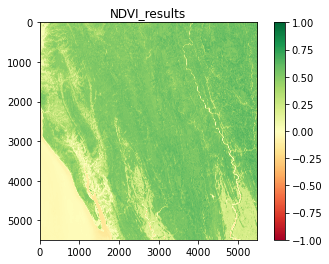

In [8]:
#Equation to calculate NDVI index
ndvi = (band_8.astype(float) - band_4.astype(float)) / (band_8 + band_4)
#create NDVI bands with the use of "create_vegetation_indices function from section 3 - User-defined functions"
#the results will be written into tif and png file with the colormap applied
ndvi_results = create_vegetation_indices('1_NDVI.tif', ndvi, '1_NDVI_cmap.png', 'NDVI_results')

<font size ="4" color ="darkgreen" face="verdana"> <b> <left>6.2.2 Normalized Difference index - NDI45 </b> </left></font><br>

Normalized Difference Index (NDI45) is an index which is related to NDVI. However it is characterized by greater linearity and shows less saturation at higher values than NDVI index. *(Delegido et al. 2010).* The formula of this index is also very similar to NDVI. Instead of band 8, it uses band 5 in the mathematical equation. 

<div class="alert alert-block alert-info">
<center><font size="5" <b> NDI45 formula:</b>  $ \frac{(NIR - RED)}{(NIR + RED)} $  = $ \frac{(B5 - B4)}{(B5 + B4)} $ </font></center>
<span style="background-color: #D3D3D3">
</div>

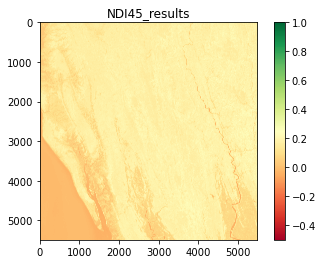

In [9]:
# Calculate NDI45 using formula above
ndi45 = (band_5.astype(float) - band_4.astype(float)) / (band_5 + band_4)
#create NDI45 band with the use of "create_vegetation_indices function from section 3 - User-defined functions"
ndi45_results = create_vegetation_indices('2_NDI45.tif', ndi45, '2_NDI45_cmap.png', 'NDI45_results')

<font size ="4" color ="darkgreen" face="verdana"> <b> <left>6.2.3 Soil Adjusted vegetation index - SAVI </b> </left></font><br>

This index uses a transformation technique that minimizes soil brightness influence from spectral vegetation indices. Apart from NIR and Red bands it uses also L parameter which stands for soil brightness correction factor *(Huete, 1988)*. For Sentinel-2 images this factor takes usually value 0.428. The formula is more complicated but also the values of SAVI needs to be normalized to the scale -1 to 1, as in our case it takes value >1.0. 

<div class="alert alert-block alert-info">
<center><font size="5" <b> SAVI formula:</b>  $ \frac{(NIR - RED)}{(NIR + RED + L)} * (1 + L) $  = $ \frac{(B8 - B4)}{(B8 + B4 + L)} * (1 + L) $ </font></center>
<span style="background-color: #D3D3D3">
</div>


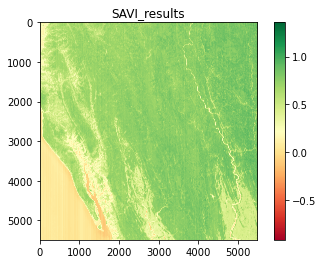

In [10]:
#Calculate SAVI using formula above
l = 0.428 # L parameter assigned
savi = (band_8.astype(float) - band_4.astype(float)) / (band_8 + band_4 + l) * (1+l)
#normalize raster results to the scale: -1 tp 1:
savi_n = normalize(savi)
#create SAVI band with the use of "create_vegetation_indices function from section 3 - User-defined functions"
savi_results = create_vegetation_indices('3_SAVI.tif', savi_n, '3_SAVI_cmap.png', 'SAVI_results')

<font size ="4" color ="darkgreen" face="verdana"> <b> <left>6.2.4 Normalized Difference Moisture Index - NDMI </b> </left></font><br>

Normalized Difference Moisture Index is very robust vegetation moisture sensitive index *(Gao, 1995)* which enables to access the information about water content in plants and spongy mesophyll structure in the vegetation canopy. For this calculation Short Wave Infra-Red band is used together with Near Infra-Red band. This index is very commonly used to evaluate vegetation moisture decline during the drought and for drought monitoring. The index has variety of applications: from agriculture and ecological applications to water bodies characteristics, vegetation water stress and wetlands monitoring.

<div class="alert alert-block alert-info">
<center><font size="5" <b> NDMI formula:</b>  $ \frac{(NIR - SWIR1)}{(NIR + SWIR1)} $  = $ \frac{(B8 - B11)}{(B8 + B11)} $ </font></center>
<span style="background-color: #D3D3D3">
</div>


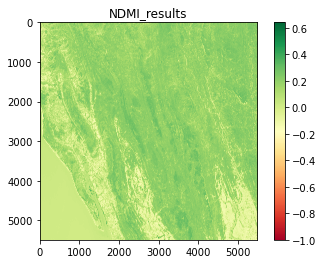

In [11]:
#Calculate NDMI using formula above
ndmi = (band_8.astype(float) - band_11.astype(float)) / (band_8 +  band_11 ) 
#create NDMI band with the use of "create_vegetation_indices function from section 3 - User-defined functions"
ndmi_results = create_vegetation_indices('4_NDMI.tif', ndmi, '4_NDMI_cmap.png', 'NDMI_results')

<font size ="4" color ="darkgreen" face="verdana"> <left> <b> 6.3 RASTER STACK OF VEGETATION INDICES </b> </left> </font>

After having all vegetation indices calculated (VIs) we can create from them unique raster stack to combine all the data together in order to make processing faster. First of all we need to list all raster products which have all the same resolution and size. Then we will combine them with the use of *rasterio* module in a single product - raster stack and we will display metadata of this raster. 

In [12]:
#import list of files (rasters) to create image stack 
from glob import glob
glist = sorted(glob("/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/*.tif")) #import list of products with the extension .tif 
glist #print list of products which will be included in raster stack

['/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/1_NDVI.tif',
 '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/2_NDI45.tif',
 '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/3_SAVI.tif',
 '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/4_NDMI.tif']

In [13]:
#read all metadata of all single raster bands: 
with rasterio.open(glist[0]) as src0:
    meta = src0.meta
meta.update(count = len(glist))
#rad each single band of vegetation indices and load them to rasterio module
with rasterio.open('/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(glist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
#save raster stack in the output folder
with rio.open('/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif') as stack_src:
    stack_data = stack_src.read(masked=True)
    stack_meta = stack_src.profile
stack_meta #display metadata of the produt 

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 5490, 'height': 5490, 'count': 4, 'crs': CRS.from_epsg(32646), 'transform': Affine(20.0, 0.0, 399960.0,
       0.0, -20.0, 2400000.0), 'tiled': False, 'interleave': 'pixel'}

<font size ="5" color ="darkgreen" face="verdana"> <left><b>7 Prepare training dataset for models </b></left></font><br>


In this part, we will load pre-prepared data (training dataset), visualize them and as final step use points coordinates to extract the values of pixel of each vegetation indices map. As it was mentioned in presentation we do not have "field-based" biomass data we will use freely-available Global dataset of forest above-ground biomass for the year 2017 prepared by ESA Biomass Climate Change Initiative. (Link to the website with database can be found <a href="https://catalogue.ceda.ac.uk/uuid/84403d09cef3485883158f4df2989b0c"> here </a>). <br>
From this dataset we used raster dataset (in geotiff format) which includes estimates of above-ground biomass AGB represented in tons/ha. <br>

Information on how to download reference raster dataset used for this training are described in PDF step-by-step guide (chapter 7 - Extra steps). <br> 

<font size ="4" color ="darkgreen" face="verdana"> <b><left>7.1 IMPORT TRAINING POINTS SHAPEFILE </left></b><br>

Here we will import point shapefile dataset from the Auxiliary data folder (path to the file was defined in the section 2- Load AuxData). Then we will plot the points over the study area, to see where the points are located, and how they are distributed. 

In [14]:
import geopandas as gpd

# Read the GeoDataFrame
gdf = gpd.read_file(points_path)

# Check if CRS is geographic, and reproject if needed
if gdf.crs.is_geographic:
    gdf = gdf.to_crs("EPSG:32646")  # Reproject to UTM Zone 46N for accurate buffering

# Save the reprojected GeoDataFrame
gdf.to_file("TheBiomass3.shp")


In [15]:
points2_path = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/TheBiomass3.shp'

OBJECTID      400
RASTERVALU    400
POINT_X       400
POINT_Y       400
geometry      400
dtype: int64


<AxesSubplot:>

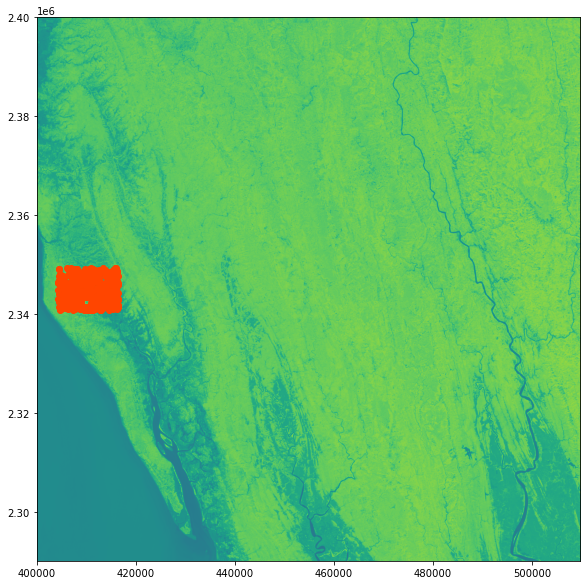

In [16]:
#READ SHAPEFILE INTO PYTHON ENVIRONMENT
pts = gpd.read_file(points2_path) #points will be read into Python using geopandas module 
print(pts.count()) #here we will display basic information about the points shapefile 

#IMPORT VEGETATION RASTER STACK USING RASTERIO PACKAGE 
VIs_stack = rasterio.open('/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif') #set path to the raster stack 
fig, ax = plt.subplots(figsize=(10,10)) #set the size of the plot 
pts.plot(ax=ax, color = 'orangered') #plot imported points and set their color 
show(VIs_stack, ax=ax) #display the image (raster stack) together with points 

<font size ="4" color ="darkgreen" face="verdana"> <b><left>7.2 PREPARE TRAINING DATASET FOR THE VEGETATION INDICES PIXEL EXTRACTION </left></b></font><br>

In order to apply machine learning models to our dataset, we need to prepare our training dataset first, which not only consists of predicted value - reference (Above-ground biomass) but it will also contain the predictors - Vegetation indices pixel means, which will be used later in the model. In order to do this we will apply following steps: 
* create buffer around points (20m) which will be used in zonal statistics 
* apply zonal statistics function from *rioxarray* moduleon vegetation indices values. We will extract mean value of pixels which fall inside the 20 m buffer
* create dataframe contains all extracted mean VI's values and write te database to the .csv file to store it locally. 
Then the dataframe created will be used as an input to our machine learning models as well as to perform descriptive statistics based on this sample of data. 

<font size ="4" color ="darkgreen" face="verdana"> <left><b>7.2.1 Create polygon shapefile - 33 m buffer around training points  </left></b></font><br>

In this step 33 m buffer around training points will be created in order to extract later the mean values of pixels. The polygon shapefile will be saved in the AuxData folder.

In [17]:
#CREATE A BUFFER AROUND TRAINING POINTS  
poly = pts.copy()  #make a copy of points shapefile previously loaded
#Buffer each point using a 33 meter circle radius and replace the point geometry with the new buffered geometry 
poly["geometry"] = pts.geometry.buffer(33) 
poly.head() 
# Export the buffered point layer as a shapefile to use in zonal stats 
poly_buffer_path = ("AGB.shp") 
poly.to_file(poly_buffer_path)

7.1 Zonal Statistics

Each vegetation index band will be read as as an numerical raster array in order to perform later zonal statistics of selected pixels. In this step we will use a function defined in the section 3 - User defined functions: zonal statistics. Each vegetation index raster will be taken into the function and based on the areas covered by buffer of points prepared previously the mean of pixel which fell inside this polygon will be calculated (extracted). This value for each point will be saved under the name of the index with the suffix _mean.

In [18]:
VI_output = "/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VI_output/"

In [19]:
#Perform zonal statistics
#First we will open each file with vegetation index representation as an xarray and save it to VIs_data variable 
#Secondly we will calculate the mean of each VIs pixel value which fell inside the polygon created before. We will save the results of statistics to new variable VIs_mean
NDVI_data = rxr.open_rasterio(VI_output + '1_NDVI.tif', masked=True).squeeze()
NDI45_data = rxr.open_rasterio(VI_output + '2_NDI45.tif', masked=True).squeeze()
SAVI_data = rxr.open_rasterio(VI_output + '3_SAVI.tif', masked=True).squeeze()
NDMI_data = rxr.open_rasterio(VI_output + '4_NDMI.tif', masked=True).squeeze()
NDVI_mean = zonal_statistics(NDVI_data)
NDI45_mean = zonal_statistics(NDI45_data)
NDMI_mean = zonal_statistics(NDMI_data)
SAVI_mean = zonal_statistics(SAVI_data)

In [20]:
# Content Check
gdf1 = create_GeoDataFrame(NDVI_mean)
print(gdf1.columns)
df1= create_DataFrame(gdf1)
print(df1.columns)

Index(['geometry', 'OBJECTID', 'RASTERVALU', 'POINT_X', 'POINT_Y', 'mean'], dtype='object')
Index(['RASTERVALU', 'mean'], dtype='object')


7.2 Create dataframes to store values of extracted pixels

In this step withe the use of geopandas module we will create four small dataframes which contains the mean values of each vegetation index for all 400 training points. To not confuse the values the dataframe needs to be created which will contain the points coordinates, AGB reference value as well as a mean value of each vegetation index substracted from rasters with zonal statistics tool. Then complete database will be displayed and saved locally as a .csv file. 

In [21]:
# Create GeoDataFrames and DataFrames with the Vegetation Indices values
gdf1 = create_GeoDataFrame(NDVI_mean)
df1 = create_DataFrame(gdf1)
df1.rename(columns={'RASTERVALU': 'AGB', 'mean': 'NDVI'}, inplace=True)

gdf2 = create_GeoDataFrame(NDI45_mean)
df2 = create_DataFrame(gdf2)
df2.rename(columns={'mean': 'NDI45'}, inplace=True)

gdf3 = create_GeoDataFrame(SAVI_mean)
df3 = create_DataFrame(gdf3)
df3.rename(columns={'mean': 'SAVI'}, inplace=True)

gdf4 = create_GeoDataFrame(NDMI_mean)
df4 = create_DataFrame(gdf4)
df4.rename(columns={'mean': 'NDMI'}, inplace=True)

# Combine all DataFrames into a single DataFrame
training_dataset = pd.concat([df1, df2, df3, df4], axis=1, join='inner')

# Inspect columns before dropping
print("Columns before dropping:", training_dataset.columns)

# Drop unnecessary columns if they exist
columns_to_drop = ['OBJECTID', 'RASTERVALU']
training_dataset = training_dataset.drop(columns=[col for col in columns_to_drop if col in training_dataset.columns])

# Write records of the training database to a CSV file
training_dataset.to_csv('training_dataset.csv', header=True, index=False)

# Display the first six rows of the database created
print(training_dataset.head())


Columns before dropping: Index(['AGB', 'NDVI', 'RASTERVALU', 'NDI45', 'RASTERVALU', 'SAVI',
       'RASTERVALU', 'NDMI'],
      dtype='object')
   AGB      NDVI     NDI45      SAVI      NDMI
0    5  0.493489  0.196120  0.701092  0.194318
1   35  0.474337  0.163631  0.686298  0.234169
2    7  0.439400  0.157514  0.621045  0.124371
3   14  0.377750  0.141749  0.557455  0.041275
4    0  0.489858  0.206118  0.703971  0.169152


In [22]:
# Combine four dataframes into a single dataset
training_dataset = pd.concat([df1, df2, df3, df4], axis=1, join='inner')

# Drop columns 'ID' and 'RASTERVALU' if they exist
columns_to_drop = ['OBJECTID', 'RASTERVALU']
training_dataset = training_dataset.drop(
    columns=[col for col in columns_to_drop if col in training_dataset.columns]
)

# Write the training dataset to a CSV file
training_dataset.to_csv('training_dataset.csv', index=False)


8 Descriptive statistics of the training dataset

8.1 Correlation Matrix

In this step we will load training dataset previously created to see the main statistical values of this extracted pixels in order later to compare these values. We will compare the values of extracted Vegetation Indices and relate them to AGB values extracted from the reference raster. Comparison will base on the Pearson correlation coefficient value (r) which in this case will be represented with the correlation matrix heatmap. Using correlation matrix we can assess not only information on how strong the relationship between AGB values and VIs values is but also the relationship between VIs one to another. 

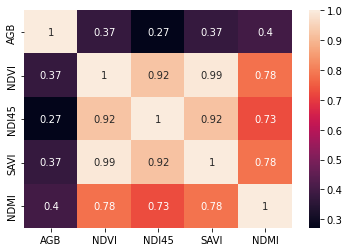

In [23]:
#Visual representation of the correlation matrix using seaborn Python module
corrMatrix = training_dataset.corr() #create first simple correlation matrix 
sns.heatmap(corrMatrix, annot=True) #plot the correlation matix as a heatmap
plt.show()

Above we can see already that all vegetation indices correlate nicely with the AGB observed from the same year. We can see this correlation values in the first row of the matrix. <br>

8.2 Correlation BETWEEN VIs AND AGB VALUES 

Now as a last step of the statistical description of the database we will plot the linear relationships in a scatterplot style between each vegetation indices values and AGB values. 

<AxesSubplot:xlabel='NDMI', ylabel='AGB'>

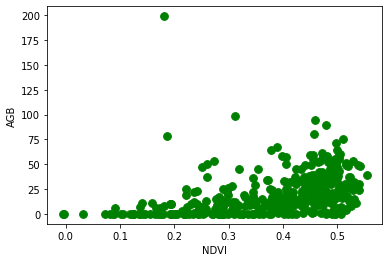

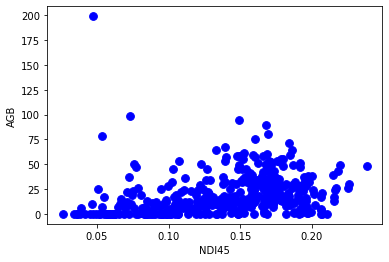

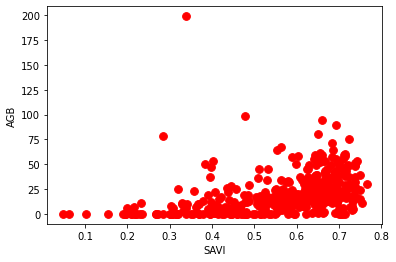

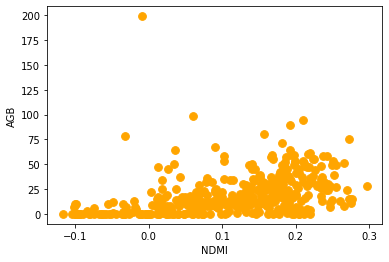

In [24]:
#Importing dataset using pandas package
df = pd.read_csv('training_dataset.csv') 
#scatterplots between all four variables and the AGB values derived from the reference dataset 
#we will plot each vegetation index against the AGB values in order to see the relationship between these values and the character of this relation. 
df.plot.scatter(x='NDVI', y='AGB', s=60,c='green')
df.plot.scatter(x='NDI45', y='AGB', s=60,c='blue')
df.plot.scatter(x='SAVI', y='AGB', s=60,c='red')
df.plot.scatter(x='NDMI', y='AGB', s=60,c='orange')

<font size ="5" color ="darkgreen" face="verdana"> <left><b>9 Above-ground biomass estimastion using Machine Learning techniques </b></left></font><br>


The goal of this exercise is to predict Above-ground biomass in and around KTP Refugee camp area before the refugee influx. Recently, different machine learning techniques, for example: support vector machine (SVN), Decision Tree, Artificial Neural Network (ANN) or Random Forest (RF) are applied very often to estimate biomass values based on remote sensing data and field surveys. For AGB estimation with machine learning algorithms non-parametric models are believed to show better prediction than linear regression models. In this tutorial then we will concentrate on two techniques, we will use all vegetation indices derived from Sentinel-2 data and test them as predictors in two regression models: 
* Multiple linear regression model 
* Random Forest regression model 
We will acquire statistics about these models and compare them, but also as a final step we will generate above-ground biomass maps based on both models to visually assess the results.
The goodness-of-fit of both models will be evaluated using coefficient of determination R^2 value. We will also evaluate the significance or importance of each vegetation index in the regression models and prediction of final values. The results will be exported in geotiff format which will enable to continue other analyses on produced biomass maps.   


<font size ="4" color ="darkgreen" face="verdana"> <b><left>9.1 MULTIPLE LINEAR REGRESSION MODEL </left></b><br>


Linear regression in statistic modelling is a method which is based on linear combinations between dependent variable (in our case: AGB values derived from the BCCI database) and predictors (independent variables).
Because we have 4 independent variables which we want to use to build the model which we will be using multiple linear regression for this purpose. <br>

The concept of multiple linear regression model is the same as single linear regression model: it estimates the relationship between quantitative dependent variable (Y) and two or more independent variables (X) using a straigh line.  

    
<div class="alert alert-block alert-info">
<center><font size="5" <b> Multilple linear regression formula:</b>  ${Y} = {\beta}_{0} +  {\beta}_{1}X_{1} + {\beta}_{2}X_{2}+ ... +{\beta}_{n}X_{n} $ </font>
    </center>
<span style="background-color: #D3D3D3">
</div>


In this part of the exercise we will use the Scikit-lear library which is a free algorithms library from the machine learning discipline, wrote in Python and based on te SciPy module. Scikit-learn makes available many simple to use but at the same time very efective tools for data analysis and data mining. We will use this library to create all tested regression models. Documentation about this model you can find also here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [25]:
#CHOOSE COLUMNS WHICH INCLUDE ALL VARIABLES (X- PREDICTORS - VIs AND y - DEPENDENT VARIABLE) WHICH WILL BE USED AS AN INPPUT TO ALL REGRESSION MODELS
# use columns names from the dataframe created previously to select predictor variables for the model 
X = df.iloc[:, 1:5].values #as predictors we are going to use following values: "NDVI_mean", "NDI45_mean", "SAVI_mean" and "NDMI_mean"
y = df.iloc[:, 0].values #dependent variable - AGB (tons/ha) is stored in the first column of the dataframe. 

After loading all predictors and dependent variable we will perform Multiple Linear regression. To do this we will follow these steps: 
* load class linear model from sklearn module
* prepare training and test data (algorithm will select these data randomly where the 30% of dataset will be assigned to test data)
* run multiple linear regression
* fit data to the model
* assess the statistics and the goodness of prepared model

In [26]:
#import necessary classes to run multiple linear regression:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm  # display the results of statistics of the model
import pandas as pd
import numpy as np

# Preparation of training and test dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  # 30% for testing

# Perform multiple linear regression
mlr_regressor = LinearRegression()
mlr_regressor.fit(x_train, y_train)  # Fit the training data

# Predict new values for test data
y_pred = mlr_regressor.predict(x_test)

# Calculate MAE and RMSE for test data
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Write calculation of the results to a separate DataFrame
mlr_results = {
    'Intercept': [mlr_regressor.intercept_],
    'Coefficients': [mlr_regressor.coef_],
    'r-squared score': [mlr_regressor.score(x_train, y_train)],
    'Mean Absolute Error (Test)': [mae],
    'Root Mean Squared Error (Test)': [rmse]
}

# Create DataFrame and display
mlr_df = pd.DataFrame(mlr_results, columns=['Intercept', 'Coefficients', 'r-squared score',
                                            'Mean Absolute Error (Test)', 'Root Mean Squared Error (Test)'])
mlr_df


,Intercept,Coefficients,r-squared score,Mean Absolute Error (Test),Root Mean Squared Error (Test)
0,-4.715454,"[15.206487710172647, -265.04784169384067, 90.31354735393941, 54.16456758027021]",0.194509,12.610261,16.062732


<font size ="4" color ="darkgreen" face="verdana"> <b><left>9.2 RANDOM FOREST REGRESSION MODEL </left></b><br>

As a type of non-linear regression model which will be used to predict AGB values over the study area we are going to use an algorithm which you probably know from the classification - Random Forest. Random Forest Regression is considered as one of the fastest machine learning algorithms and in the literature it gives good results in prediction of biomass values. This technique is based on decision trees which facilitate the decision process. The decsion tree in random forest is built in iterative way from the roots up to its leaves. Each tree in random forest is built with different defined algorithm by selection of random sample coming from pre-deifned training dataset. In our case we will set three parameters to built our tree: n_estimators which control the number of trees nside the classifier, max_depth which is the limit set to each to grow and n_jobs to faster the procesisng to use all processor to calculate the regression.<br>
    
<img src="https://www.frontiersin.org/files/Articles/649866/fbioe-09-649866-HTML/image_m/fbioe-09-649866-g003.jpg" width=300 height = 300/><br>

*image source:https://doi.org/10.3389/fbioe.2021.649866*

Documentation on Random Forest Regression in Python can be found here : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [27]:
#Preapare training dataset for the model 
features = df.iloc[:, 1:5].values #predictor variables 
AGB_obs = df.iloc[:, 0].values #defined dependent variable
from sklearn.model_selection import train_test_split #import class which enables to create the training and test data based on the input parameters 
train_features, test_features, train_AGB_obs, test_AGB_obs = train_test_split(features, AGB_obs, test_size = 0.3, random_state=0) #split training dataset into train and test data in the proportion that 30% of the dataset is saved for testing

#RUN RANDOM FOREST REGRESSION MODEL
from sklearn.ensemble import RandomForestRegressor #Import RandomForestRegressor class from sklearn module
#RFReg = RandomForestRegressor(n_estimators= 1000, max_depth = 30, n_jobs=-1, random_state= 0) # create Random Forest model using 500 as a number of estimators
#RFReg.fit(train_features, train_AGB_obs) #fit the training dataset into the model 
# Create Random Forest model using the best parameters
RFReg = RandomForestRegressor(n_estimators=500, 
                              max_depth=30, 
                              min_samples_split=10, 
                              min_samples_leaf=8,
                              max_features='sqrt',
                              n_jobs=-1, 
                              random_state=0)

# Fit the training dataset into the model
RFReg.fit(train_features, train_AGB_obs)


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=8,
                      min_samples_split=10, n_estimators=500, n_jobs=-1,
                      random_state=0)

In [28]:
## Search for Best Parameterization
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 8]
}

# Initialize Random Forest and GridSearch
RFReg = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_search = GridSearchCV(estimator=RFReg, param_grid=param_grid, cv=5, scoring='r2', verbose=2)

# Fit GridSearch to training data
grid_search.fit(train_features, train_AGB_obs)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Fit the model with optimized hyperparameters
RFReg_optimized = RandomForestRegressor(**grid_search.best_params_, random_state=0, n_jobs=-1)
RFReg_optimized.fit(train_features, train_AGB_obs)

# Predict and assess
AGB_obs_pred_rf = RFReg_optimized.predict(test_features)
r_square_rf = metrics.r2_score(test_AGB_obs, AGB_obs_pred_rf)
print('Improved r-square:', r_square_rf)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   1.3s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   0.4s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, total=   0.4s
[CV] max_depth=10, min_samples_leaf=1, min_samples_s

KeyboardInterrupt: 

In [28]:
#predict AGB values based on the created model with parameters pre-defined
AGB_obs_pred_rf = RFReg.predict((test_features))
from sklearn import metrics #assessing the results of estimation using R2 metric 
r_square_rf = metrics.r2_score(test_AGB_obs, AGB_obs_pred_rf)
print('r-square:', r_square_rf) #dipslay r2 metric of the calculated model 

r-square: 0.2559671767312278


In [29]:
# Predict AGB values based on the created model with parameters pre-defined
AGB_obs_pred_rf = RFReg.predict(test_features)

# Import metrics for assessment
from sklearn import metrics
import numpy as np

# Calculate metrics
r_square_rf = metrics.r2_score(test_AGB_obs, AGB_obs_pred_rf)
mae_rf = metrics.mean_absolute_error(test_AGB_obs, AGB_obs_pred_rf)
rmse_rf = np.sqrt(metrics.mean_squared_error(test_AGB_obs, AGB_obs_pred_rf))

# Display the results
print('r-square:', r_square_rf)   # R2 metric of the calculated model
print('Mean Absolute Error (MAE):', mae_rf)  # MAE of the model
print('Root Mean Squared Error (RMSE):', rmse_rf)  # RMSE of the model


r-square: 0.2559671767312278
Mean Absolute Error (MAE): 11.684993354364451
Root Mean Squared Error (RMSE): 16.50174979464302


In [30]:
#here we will produce the numerical values of the importance of each VIs value to the final model 
rf_features = df.iloc[:, 1:10] #list of predictors used in the model 
features_list = list(rf_features.columns) # list the features used in the model
importances = list(RFReg.feature_importances_) # importance of each predictor on the whole model 
#the values of the importance will be calculated based on the model 
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];#display results as a pair observations

Variable: NDMI                 Importance: 0.3
Variable: SAVI                 Importance: 0.26
Variable: NDVI                 Importance: 0.23
Variable: NDI45                Importance: 0.21


<font size ="5" color ="darkgreen" face="verdana"> <left><b>10 Create above-ground biomass maps </b></left></font><br>


These will be the last steps of this tutorial. We have created machine learning regression models and now we will use these model to create final output - Above-ground biomass maps. We will create and store locally the geotiff images produced. As an input to the predicted AGB biomass maps we will use raster stack previously created which contains the vegetation indices bands as well as the training dataset used in the models. 
Later you can use these maps to compare for example your results with the global biomass maps which you can find in the internet - list of the internet resources for this can be found in the additional reading materials (section 11). You can also continue calculations on this raster with AGB values and produce for example carbon mass map by dividing this raster by about 0.5 to receive carbon content in this forest area. <br>

<font size ="4" color ="darkgreen" face="verdana"> <left><b>10.1 Above-ground biomass raster based on linear regression model </b></left></font><br>

First of all we will start with the parameters to input and output dataset. Then we will use a function predifined in user defined functions to calculate and save the raster as AGB biomass map. 

In [34]:
#Here we create the geotiff file which will contain predicted AGB values 
inpRaster= '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif' #define path to the input raster (on which we will make prediction
df_train = pd.read_csv('training_dataset.csv') #path to the dataset with the training data 
data = df_train[['NDVI','NDI45','SAVI','NDMI']] # list of predictors 
label = df_train['AGB'] # predicted variable (dependent variable AGB)
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly) #with gdal module we will open the input raster 
rows = ds.RasterYSize #we need to asisgn the size of the raster - rows number in the raster dataset 
cols = ds.RasterXSize # we need to asisgn the size of the raster - columns number in the raster dataset 
bands = ds.RasterCount #we will also get the number of bands in the input raster (in our case 4)
geo_transform = ds.GetGeoTransform() #with geotransform class we will set projection to the raster 
projection = ds.GetProjectionRef() #projection of the raster needs to be the same as input raster 
array = ds.ReadAsArray() #raster will be converted to an array
ds = None
array = np.stack(array,axis=2) #with numpy stack we will join the sequence of the arrays along a new axes  
array = np.reshape(array, [rows*cols,bands]) #we give a final shape to the output raster: number of columns and rows and bands must be the same as input file 
test = pd.DataFrame(array, dtype='float32')  # we will create raster with the same datatype 'float32' as input raster 
outRaster = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/AGB_mlr.tif' #path to the output raster - where it will be saved
#PREDICTION OF ABOVEGROUND BIOMASS VALUES BASED ON THE TRAINING DATASET AND THE RASTER STACK PROVIDED 
AGB_mlr = mlr_regressor.predict(test) #run the prediction on multiple linear regression model previously created 
estimation = AGB_mlr.reshape((rows,cols)) #reshape output array into the array with the same defined previously number of columns and rows. 

#export classified image using 'createGeotiff' function provided in the section number 3
createGeotiff(outRaster,estimation,geo_transform,projection)

<font size ="4" color ="darkgreen" face="verdana"> <left><b>10.2 Above-ground biomass raster based on Random Forest Regression Model </b></left></font><br>

We will use pre-defined parameters to built the new raster dataset. Predicted raster product and the one produced in the step before will be stored in folder */shared/Training/PY02_ForestBiomass_Sentinel2/Processing/*  

In [ ]:
#Here we will run script which is very similar to the cell above, this time taking as a predictor of values Random Forest Regression model 
inpRaster= '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif' #define path to the input raster (on which we will make prediction
outRaster = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/AGB_RFReg.tif' #path to the output raster - where it will be saved
df_train = pd.read_csv('training_dataset.csv') #path to the dataset with the training data 
data = df_train[['NDVI','NDI45','SAVI','NDMI']] # list of predictors 
label = df_train['AGB']  # predicted variable (dependent variable AGB)
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly) #with gdal module we will open the input raster 
rows = ds.RasterYSize #we need to asisgn the size of the raster - rows number in the raster dataset 
cols = ds.RasterXSize # we need to asisgn the size of the raster - columns number in the raster dataset 
bands = ds.RasterCount  #we will also get the number of bands in the input raster (in our case 4)
geo_transform = ds.GetGeoTransform() #with geotransform class we will set projection to the raster 
projection = ds.GetProjectionRef()  #projection of the raster needs to be the same as input raster 
array = ds.ReadAsArray() #raster will be converted to an array
ds = None
array = np.stack(array,axis=2)  #with numpy stack we will join the sequence of the arrays along a new axes 
array = np.reshape(array, [rows*cols,bands])  #we give a final shape to the output raster: number of columns and rows and bands must be the same as input file 
test1 = pd.DataFrame(array, dtype='float32') # we will create raster with the same datatype 'float32' as input raster 
#PREDICTION OF ABOVEGROUND BIOMASS VALUES BASED ON THE TRAINING DATASET AND THE RASTER STACK PROVIDED 
AGB_RFReg = RFReg.predict(test1) #run the prediction on Random Forest Regression model previously created 
estimation = AGB_RFReg.reshape((rows,cols)) #reshape output array into the array with the same defined previously number of columns and rows
##export classified image using 'createGeotiff' function provided in the section number 3
createGeotiff(outRaster,estimation,geo_transform,projection)

<font size ="4" color ="darkgreen" face="verdana"> <left><b>10.3 Visualization of the Above-ground biomass maps produced </b></left></font><br>

In this final steps we will see the visual differences in the biomass produced with two different models linear and non-linear random forest regression model. We can also see the statistics so the min, max, mean values of AGB (tons/ha) in selected study area. We can see that the Above ground biomass map produced based on random forest regression model gave better results in terms of prediction of these values and their range over the study area. This range is more realistic as the range of linear regression model based image has some outliers. 

In [27]:
#read the output raster and open it
AGB_mlr = rasterio.open('/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/AGB_mlr.tif')
AGB_mlr_array = AGB_mlr.read() # Read all bands as an array
# Calculate statistics for the image
stats = []
for band in AGB_mlr_array:
    stats.append({
    'min': band.min(),
    'mean': band.mean(),
    'median': np.median(band),
    'max': band.max()})
print(stats)

[{'min': -68.769714, 'mean': 25.06947, 'median': 27.965843, 'max': 64.730804}]


In [28]:
#read the output raster and open it
AGB_RF = rasterio.open('/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/AGB_RFReg.tif')
AGB_RF_array = AGB_RF.read() # Read all bands as an array
# Calculate statistics for the image
stats = []
for band in AGB_RF_array:
    stats.append({
    'min': band.min(),
    'mean': band.mean(),
    'median': np.median(band),
    'max': band.max()})
print(stats)

[{'min': 0.32, 'mean': 25.955341, 'median': 25.31, 'max': 78.53}]


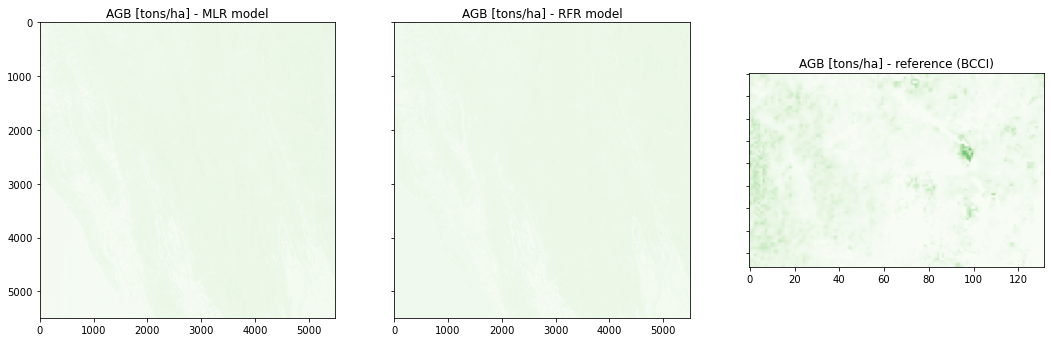

In [30]:
#Plot the reference data (AGB refernce map for the year 2017 and confront it with the results produced with the regression models 
AGB_ref = rasterio.open('/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/AuxData2/Biomass2016_Ha_Ton.tif')
AGB_ref_array = AGB_ref.read() # Read all bands as an array
fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize=(18,18)) #create a plot of three images one next to another  
ax1.imshow(AGB_mlr_array[0], cmap= 'Greens', vmin = 0, vmax = 400)  #show the first image - AGB derived from the Multiple Linear Regression model
ax1.set_title('AGB [tons/ha] - MLR model') 
ax2.imshow(AGB_RF_array[0], cmap= 'Greens',vmin = 0, vmax = 400) 
ax2.set_title('AGB [tons/ha] - RFR model') 
ax3.imshow(AGB_ref_array[0], cmap= 'Greens',vmin = 0, vmax = 400) 
ax3.set_title('AGB [tons/ha] - reference (BCCI)')
for ax in fig.get_axes(): 
    ax.label_outer() 


<font size ="4" color ="darkgreen" face="verdana"> <left><b>11 Additional Machine Learning Techniques Implementation for Comparison</b></left></font><br>


11.1 Gradient Boosting Regressor Implementation

In [1]:
## Gradient boosting Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [4]:
# Load the dataset
df_train = pd.read_csv('training_dataset.csv')

# Define predictors and labels
features = df_train[['NDVI', 'NDI45', 'SAVI', 'NDMI']].values  # Predictor variables
AGB_obs = df_train['AGB'].values  # Target variable

# Split into training and testing sets
train_features, test_features, train_AGB_obs, test_AGB_obs = train_test_split(
    features, AGB_obs, test_size=0.3, random_state=0)

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=200,  # Number of trees
    max_depth=6,       # Maximum depth of trees
    learning_rate=0.05, # Learning rate
    random_state=0
)

# Train the model
gb_model.fit(train_features, train_AGB_obs)

# Make predictions
AGB_obs_pred_gb = gb_model.predict(test_features)

# Evaluate the model
r2_gb = r2_score(test_AGB_obs, AGB_obs_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(test_AGB_obs, AGB_obs_pred_gb))

print(f"R^2: {r2_gb}")
print(f"RMSE: {rmse_gb}")

# Save the predictions for raster data
inpRaster = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif'
outRaster = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/AGB_GB_Prediction.tif'

# Read raster data and prepare for prediction
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
array = ds.ReadAsArray()
ds = None

# Prepare raster data
array = np.stack(array, axis=2)
array = np.reshape(array, [rows * cols, bands])

# Predict AGB for raster data
AGB_GB = gb_model.predict(array).reshape(rows, cols)

# Save the prediction as GeoTIFF
createGeotiff(outRaster, AGB_GB, geo_transform, projection)

print(f"Predictions saved to {outRaster}")


R^2: -1.643002663331659
RMSE: 31.101601374899136


NameError: name 'createGeotiff' is not defined

In [ ]:
## Support Vector Regression Implementation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
df_train = pd.read_csv('training_dataset.csv')

# Define predictors and labels
features = df_train[['NDVI', 'NDI45', 'SAVI', 'NDMI']].values  # Predictor variables
AGB_obs = df_train['AGB'].values  # Target variable

# Split into training and testing sets
train_features, test_features, train_AGB_obs, test_AGB_obs = train_test_split(
    features, AGB_obs, test_size=0.3, random_state=0)

# Standardize features for SVR
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Initialize Support Vector Regressor with RBF kernel
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the model
svr_model.fit(train_features, train_AGB_obs)

# Make predictions
AGB_obs_pred_svr = svr_model.predict(test_features)

# Evaluate the model
r2_svr = r2_score(test_AGB_obs, AGB_obs_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(test_AGB_obs, AGB_obs_pred_svr))

print(f"R^2: {r2_svr}")
print(f"RMSE: {rmse_svr}")

# Save the predictions for raster data
inpRaster = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/VIs_stack.tif'
outRaster = '/home/dewan/Desktop/snaptoolbox/PY02_ForestBiomass_Sentinel2/Processing/AGB_SVR_Prediction.tif'

# Read raster data and prepare for prediction
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
array = ds.ReadAsArray()
ds = None

# Prepare raster data
array = np.stack(array, axis=2)
array = np.reshape(array, [rows * cols, bands])

# Standardize raster data
array_scaled = scaler.transform(array)

# Predict AGB for raster data
AGB_SVR = svr_model.predict(array_scaled).reshape(rows, cols)

# Save the prediction as GeoTIFF
createGeotiff(outRaster, AGB_SVR, geo_transform, projection)

print(f"Predictions saved to {outRaster}")


R^2: 0.03975946229166083
RMSE: 20.210179440515628



<font size ="5" color ="darkgreen" face="verdana"> <center><b> Thank you!</b></center></font><br>
